In [5]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3060 Laptop GPU


Removing shadow from images to improve automatic maks making

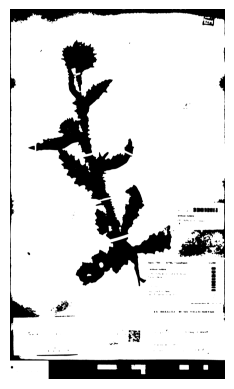

In [9]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/home/floris/Projects/NTNU/images/gbif_images/187108471_a.jpg')

# convert to LAB color space
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

# apply CLAHE to the L-channel (lightness channel) -> removes shadows (approx.)
l, a, b = cv2.split(lab)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
cl = clahe.apply(l)

# merge the CLAHE enhanced L-channel with the original A and B channel -> convert back to BGR
limg = cv2.merge((cl, a, b))
lab = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# apply heatmap with cool
heatmap = cv2.applyColorMap(lab, cv2.COLORMAP_COOL)

# create threshold mask
binary = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(binary, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# apply median blur
output = cv2.medianBlur(thresh, 21)

# save image
cv2.imwrite('test.jpg', output)

plt.imshow(output, cmap='gray')
plt.axis('off')
plt.show()

Heatmap test

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load the image
image_path = '/home/floris/Projects/NTNU/images/gbif_images/187108471_a.jpg'
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Normalize the image to the range [0, 1]
normalized_image = gray_image / 255.0

# Apply a colormap (there are many available colormaps like 'hot', 'cool', 'afmhot'
heatmap_image_hot = plt.cm.hot(normalized_image)
heatmap_image_cool = plt.cm.cool(normalized_image)
heatmap_image_afmhot = plt.cm.afmhot(normalized_image)

# Save the heatmap images without axes
plt.imsave('heatmap_image_hot.png', heatmap_image_hot)
plt.imsave('heatmap_image_cool.png', heatmap_image_cool)
plt.imsave('heatmap_image_afmhot.png', heatmap_image_afmhot)

Augment dataset

In [54]:
from torchvision.transforms.functional import adjust_hue
from torchvision import transforms
from roboflow import Roboflow
from PIL import Image
import shutil
import torch
import os

def hue_degree_to_hue_value():
    return (torch.rand(1).item() * 60 - 30) / 360.0  # Random hue between -30 and +30 degrees

def augment_image(pil_img, name):
    images = [pil_img.copy()]  # Start with the original image

    # Apply a noticeable hue shift
    hue_adjustment = hue_degree_to_hue_value()
    images.append(adjust_hue(pil_img.copy(), hue_adjustment))

    # Apply a more pronounced saturation change
    images.append(transforms.ColorJitter(saturation=0.5)(pil_img.copy()))  # 50% less to 50% more saturation

    # Apply a more noticeable brightness change
    images.append(transforms.ColorJitter(brightness=0.5)(pil_img.copy()))  # 50% darker to 50% brighter

    # Apply a stronger contrast change
    images.append(transforms.ColorJitter(contrast=0.5)(pil_img.copy()))  # 50% less to 50% more contrast

    names = [name] + [name.replace('.jpg', '_hue.jpg'), name.replace('.jpg', '_sat.jpg'), name.replace('.jpg', '_bright.jpg'), name.replace('.jpg', '_cont.jpg')]
    return images, names

def augment_images(image_paths):
    augmented_batch = []
    for img_path in image_paths:
        pil_img = Image.open(img_path)  # Open the image file
        augmented_batch.append((augment_image(pil_img, os.path.basename(img_path))))  # Apply augmentation and extend the batch list
    return augmented_batch

# download dataset
rf = Roboflow(api_key="x5pZ44ydkd9As40Mglzv")
project = rf.workspace("ntnuscaledetection").project("ntnu_segmentation")
version = project.version(10)
dataset = version.download("yolov8")

# get paths
path = os.path.join(dataset.location, 'train', 'images')
label_path = os.path.join(dataset.location, 'train', 'labels')

image_paths = [os.path.join(path, i) for i in os.listdir(path) if i.endswith(('.png', '.jpg', '.jpeg'))]

# augment images
augmented_images = augment_images(image_paths)

# save images and labels
for idx, item in enumerate(augmented_images):
    original_name = item[1][0].replace('.jpg', '.txt')
    original_label = os.path.join(label_path, original_name)
    # copy original label with new names (hue, sat, bright, cont)
    for name in item[1][1:]:
        new_label = os.path.join(label_path, name.replace('.jpg', '.txt'))
        shutil.copy(original_label, new_label)
    
    # save images
    for name, image in zip(item[1], item[0]):
        image.save(os.path.join(path, name))

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Ntnu_segmentation-10 in yolov8:: 100%|██████████| 87/87 [00:00<00:00, 5856.84it/s]


Deploy model

In [9]:
from roboflow import Roboflow
rf = Roboflow(api_key="x5pZ44ydkd9As40Mglzv")
project = rf.workspace("ntnuscaledetection").project("ntnu_segmentation")
version = project.version(5)
version.deploy("yolov8-seg", "../models", "plant_segmentation_v6.pt")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`
View the status of your deployment at: https://app.roboflow.com/ntnuscaledetection/ntnu_segmentation/5
Share your model with the world at: https://universe.roboflow.com/ntnuscaledetection/ntnu_segmentation/model/5


Test model

In [ ]:
from ultralytics import YOLO
import os

images = [os.path.join('../images/gbif_images', image) for image in os.listdir('../images/gbif_images')]

version = 20
confidence=0.4
_type = 'last'

for batch in range(0, len(images), 10):
    model = YOLO(f'../models/plant_segmentation_v{version}_{_type}.pt')
    res = model(images[batch:batch+10], save=True, iou=0.4, conf=confidence, verbose=False)

In [8]:
import os
import shutil

path = '../models/runs/segment'
conf_str = str(confidence).replace('.', '_')
save_path = f'/home/floris/Projects/NTNU/images/segment_eval_v{version}_{_type}_conf{conf_str}'
os.makedirs(save_path, exist_ok=True)

preds = os.listdir(path)
for dir in preds:
    for img in os.listdir(os.path.join(path, dir)):
        shutil.move(os.path.join(path, dir, img), save_path)
        
shutil.rmtree(path)

Resize images

In [31]:
from PIL import Image
import numpy as np
import cv2


def resize_image_with_aspect_ratio(img_path, target_width, target_height):
    # Open the original image
    img = Image.open(img_path)
    
    # Calculate the ratio of the target dimensions
    target_ratio = target_width / target_height
    # Calculate the ratio of the original dimensions
    img_ratio = img.width / img.height
    
    # Determine the size to which the original image is to be resized
    if img_ratio > target_ratio:
        # Width is the limiting dimension
        new_width = target_width
        new_height = round(target_width / img_ratio)
    else:
        # Height is the limiting dimension
        new_height = target_height
        new_width = round(target_height * img_ratio)
    
    # Resize the original image
    resized_img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create a new image with a black background and the target size
    new_img = Image.new("RGB", (target_width, target_height), (0, 0, 0))
    
    # Calculate the position to paste the resized image onto the new image
    x = (target_width - new_width) // 2
    y = (target_height - new_height) // 2
    
    # Paste the resized image onto the new image
    new_img.paste(resized_img, (x, y))
    
    return new_img


image = cv2.imread('../images/upload/1802796785.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

from ultralytics import YOLO

model = YOLO('../models/plant_segmentation_v2.pt')
results = model(image)

import matplotlib.pyplot as plt

new_image = resize_image_with_aspect_ratio('../images/upload/1802796785.jpg', 640, 640)

plt.imshow(new_image)